# Training

In this notebook we will go through the training steps of our model. For the images, we will use a CNN model since convolutions are the most prominent choice for consuming images. The CNN model will extract features from the images, and then we can use these features together with the vectorized prompts to train an RNN that can generate text.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape, LSTM, TimeDistributed
from keras.optimizers import Adam
from keras.utils import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [2]:
word2vec_model = Word2Vec.load("word2vec.model")
two_m_word2vec_model = Word2Vec.load("2m_word2vec.model")
df = pd.read_pickle("ready_to_train.pkl")

In [3]:
image_data = np.stack(df['normalized_array'].values)
image_data.shape

(10000, 128, 128, 3)

In [4]:
# For the prompt data, we need to pad them so they are all the same length (the longest array is 79)
prompt_data = pad_sequences(df['2m_vectorized_prompt'], maxlen=79, dtype='float32', padding='post', value=0.0)
#prompt_data = pad_sequences(df['vectorized_prompt'], maxlen=79, dtype='float32', padding='post', value=0.0)
prompt_data.shape

(10000, 79, 100)

In [5]:
images_training_set = image_data[:8000]
images_test_set = image_data[8000:9000]
images_val_set = image_data[9000:]

prompt_training_set = prompt_data[:8000]
prompt_test_set = prompt_data[8000:9000]
prompt_val_set = prompt_data[9000:]

In [24]:
def custom_activation(x):
    """
    This is a custom activation function for the model's output layer
    to ensure that the output values are ranged between the minimum and maximum
    values of the word embeddings.
    """
    min = np.min(prompt_data)
    max = np.max(prompt_data)
    new_val = (max - min) / 2.0 * K.tanh(x) + (max + min) / 2

    return new_val

In [37]:
model = Sequential()

# CNN
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Reshape((1, -1)))

# RNN
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(100, activation=custom_activation, kernel_regularizer='l2'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='cosine_similarity', metrics=['accuracy'])

#model.summary()

In [38]:
history = model.fit(x=images_training_set, y=prompt_training_set, epochs=20, batch_size=32, validation_data=(images_val_set, prompt_val_set))

Epoch 1/20
250/250 [==============================] - 8s 26ms/step - loss: 0.1557 - accuracy: 0.0140 - val_loss: -0.0418 - val_accuracy: 0.0166
Epoch 2/20
250/250 [==============================] - 5s 22ms/step - loss: -0.0563 - accuracy: 0.0165 - val_loss: -0.0439 - val_accuracy: 0.0153
Epoch 3/20
250/250 [==============================] - 6s 25ms/step - loss: -0.0590 - accuracy: 0.0161 - val_loss: -0.0443 - val_accuracy: 0.0153
Epoch 4/20
250/250 [==============================] - 6s 22ms/step - loss: -0.0613 - accuracy: 0.0157 - val_loss: -0.0444 - val_accuracy: 0.0162
Epoch 5/20
250/250 [==============================] - 5s 21ms/step - loss: -0.0638 - accuracy: 0.0152 - val_loss: -0.0443 - val_accuracy: 0.0138
Epoch 6/20
250/250 [==============================] - 5s 22ms/step - loss: -0.0664 - accuracy: 0.0152 - val_loss: -0.0435 - val_accuracy: 0.0146
Epoch 7/20
250/250 [==============================] - 5s 21ms/step - loss: -0.0687 - accuracy: 0.0152 - val_loss: -0.0435 - val_acc

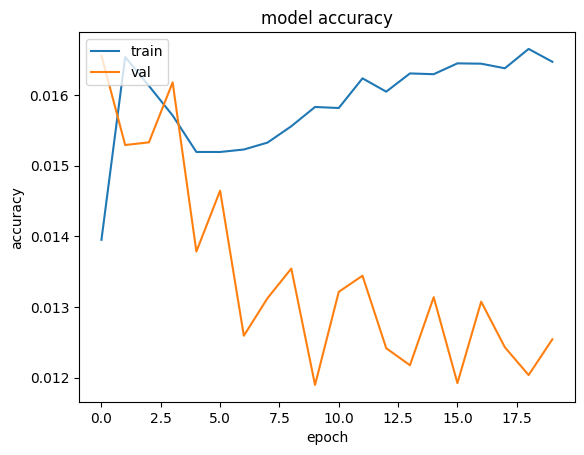

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

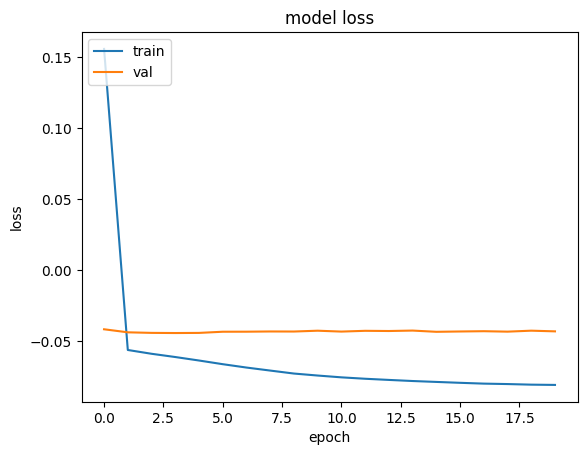

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
print("Evaluation on test data")
results = model.evaluate(images_test_set, prompt_test_set)
print("test loss, test acc:", results)

Evaluation on test data
32/32 [==============================] - 1s 20ms/step - loss: -0.0463 - accuracy: 0.0121
test loss, test acc: [-0.04628176987171173, 0.012101265601813793]


In [52]:
img_index = 9999
img = df.iloc[img_index]['image']
img_arr = df.iloc[img_index]['normalized_array']
prediction = model.predict(np.expand_dims(img_arr, axis=0))

1/1 [==============================] - 0s 190ms/step


Image:


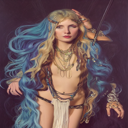

Predicted prompt:
detailed, achine, abstact, artstation, imaginational, Atek, kishin, shardula, intricate, bougureau


In [53]:
prediction_prompt = []

for word in prediction[0]:
    similar_words = two_m_word2vec_model.wv.similar_by_vector(word)

for word in similar_words:
    prediction_prompt.append(word[0])

prompt = ', '.join(prediction_prompt)

print("Image:")
display(img)
print("Predicted prompt:")
print(prompt)

In [15]:
# Uncomment to save the model to a file
#model.save("img2prompt_model")